# Visit individual Calexp_Background from Selected visits LSST in Auxtel

- author Sylvie Dagoret-Campagne
- creation date 2024-05-04
- last update 2024-05-15
- affiliation : IJCLab
- **w_2024_16**

``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399


``Shemas``:
https://dm.lsst.org/sdm_schemas/browser/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm


import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits
from astropy.wcs import WCS


import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize']= 'x-large'
plt.rcParams['ytick.labelsize']= 'x-large'

In [2]:
import gc

In [3]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time


In [4]:
import lsst.daf.butler as dafButler
#import lsst.summit.utils.butlerUtils as butlerUtils

In [5]:
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom

In [6]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [7]:
transform = AsinhStretch() + PercentileInterval(99.)

### import rubinsimphot

In [8]:
machine_name = os.uname().nodename
path_rubinsimphot = "repos/repos_w_2024_17/rubinsimphot/src"
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    print("Set environment for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)
elif 'dagoret-nb' in machine_name:
    print("Set environment for USDF Rubin Science Platform")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)    
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environment named conda_py310")
else:
    print(f"Your current machine name is {machine_name}. Check your python environment")

Set environment for USDF Rubin Science Platform


In [9]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir

In [10]:
import sys
sys.path.append('../lib')
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections_auxtel import *

LSST site name validated as LSST observatory


In [11]:
from importlib.metadata import version
the_ver = version('getObsAtmo')
print(f"Version of getObsAtmo : {the_ver}")

Version of getObsAtmo : 0.1.1


In [12]:
from getObsAtmo import ObsAtmo
emul_atm = ObsAtmo()
WL = emul_atm.GetWL()

LSST site name validated as LSST observatory


In [13]:
am0 =1.20    # airmass
pwv0 = 5.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
tau0= 0.04 # Vertical Aerosol depth (VAOD) 
beta0 = 1.2 # Aerosol Angstrom exponent
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

/home/d/dagoret/repos/repos_w_2024_17/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


In [14]:
all_Sigb = {}

for index,f in enumerate(filter_tagnames): 
    wl = pc.bandpass_inst[f].wavelen
    tr = pc.bandpass_inst[f].sb
    Sigb = np.trapz(tr/wl,wl)
    all_Sigb[f] = Sigb 
pd.DataFrame(all_Sigb, index=['Sigmab']).round(4)

u       g       r       i      z     y
Sigmab  0.0055  0.1961  0.1434  0.1481  0.085  0.03

### Import statements that we will need later

Let's make a new plot and metric tool, we'll base it on the example in the getting started guide.

In [15]:
# INSERT YOUR collection and tract
# for rehearsal use collection 2 which have CCDvisit
butlerRoot = "/repo/embargo"

collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
#collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985'
collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240414/w_2024_15/PREOPS-5069' # COMPLETED
collectionn = collection
#collections = [collection1,collection2,collection3]
collections = [collection]
collectionStr = collectionn.replace("/", "_")
fn_ccdVisit_tracts_patches = f"ccdVisittractpatch_{collectionStr}.csv"
instrument = 'LATISS'
skymapName = "latiss_v1"
where_clause = "instrument = \'" + instrument+ "\'"
tract = 3864 # mostly for light-curves
patch_sel = 236
band = 'g'
#tract = 5615
# tract = 5634 # interesting to view calib parameters
suptitle = collectionStr + f" inst = {instrument} tract = {tract}"

In [16]:
#dataId = {"skymap": "latiss_v1", "tract": 5615, "instrument": "LATISS"}
dataId = {"skymap": skymapName, "tract": tract, "instrument": instrument}
repo = '/sdf/group/rubin/repo/oga/'
butler = dafButler.Butler(repo)
#t = Butler.get(table_sel, dataId=dataId, collections=collections)
registry = butler.registry

In [17]:
skymap = butler.get('skyMap', skymap=skymapName, collections=collections)

In [18]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

In [19]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

In [20]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4

## Get pixel scale

In [21]:
import lsst.geom as geom
import lsst.sphgeom

skymap = butler.get('skyMap', skymap=skymapName, collections=collections )
tractInfo = skymap.generateTract(tract)
for patch in tractInfo:    
    patchID = patch.getSequentialIndex()
        
    ibb=patch.getInnerBBox()
    tWCS=tractInfo.getWcs()
       
    # loop on the 4 corners
    for icorn,corner in enumerate(ibb.getCorners()):
        p = geom.Point2D(corner.getX(), corner.getY())
        coord = tWCS.pixelToSky(p)


In [22]:
tWCS

FITS standard SkyWcs:
Sky Origin: (122.4365482234, -36.4462809917)
Pixel Origin: (28499, 28499)
Pixel Scale: 0.1 arcsec/pixel

In [23]:
#arcsec/pixel
pixel_scale = tWCS.getPixelScale().asArcseconds()

## Selected visits

In [24]:
if 1:
    # get the csv file produced by stat_on_visits_LSSTAuxtel.ipynb in ../Visits
    #file_selected_visits = "../Visits/ccdVisittractpatch_LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985.csv"
    file_selected_visits = os.path.join("../Visits",fn_ccdVisit_tracts_patches)
    
    df_myselectedvisits = pd.read_csv(file_selected_visits,index_col=0)

    # select the band
    cut = (df_myselectedvisits.band == band) &  (df_myselectedvisits.tractID == tract) & (df_myselectedvisits.patchID == patch_sel)
    df_myselectedvisits = df_myselectedvisits[cut]

    #move the visitid as a column not to loose it during the merge 
    df_myselectedvisits.reset_index(inplace=True) 


Note here:
- zeroPoint is in ABMag
- skyBg is in ADU (but don't know if in pixel or in arcsec2)
- skyNoise is in ADU (but don't know if in pixel or in arcsec2)

In [25]:
index = 10
visitId = df_myselectedvisits.iloc[index]['visitId']

In [26]:
df_myselectedvisits.iloc[index]

ccdVisitId      42538709760
visitId       2023112000307
band                      g
detector                  0
ra                122.49652
dec              -36.207792
llcra            122.430256
llcdec           -36.261638
ulcra            122.564496
ulcdec           -36.260256
urcra            122.562692
urcdec            -36.15391
lrcra            122.428634
lrcdec            -36.15529
ccdVid           1619012864
Vid                60900045
nightObs           20231120
tractID                3864
patchID                 236
zeroPoint         28.081877
airmass             1.07195
skyBg              2.748896
skyNoise           7.511963
expTime                30.0
Name: 10, dtype: object

In [27]:
datasetType = 'calexpBackground'
dataId = {'visit': visitId, 'instrument':instrument , 'detector': 0}
datasetRefs = registry.queryDatasets(datasetType, dataId=dataId, collections  = collections)

for i, ref in enumerate(datasetRefs):
    print(ref.dataId)
    print("band:", ref.dataId['band'])
    band = ref.dataId['band']

{instrument: 'LATISS', detector: 0, visit: 2023112000307, band: 'g', day_obs: 20231120, physical_filter: 'SDSSg_65mm~empty'}
band: g


## One Calexp Background

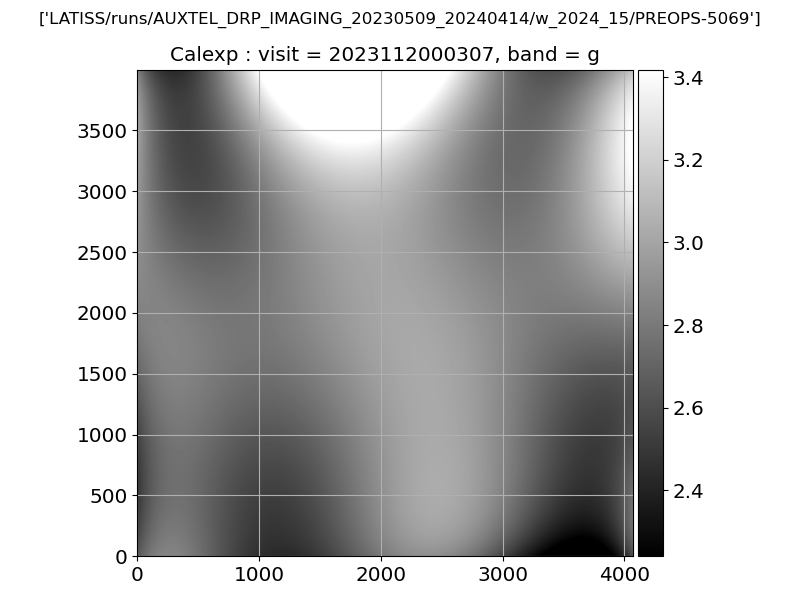

In [28]:
%matplotlib widget

bkgd = butler.get('calexpBackground', **dataId,collections=collections)
img = bkgd.getImage()
#wcs = img.getWcs()
#bbox = img.getBBox()
#corners_ra, corners_dec = get_corners_radec(wcs, bbox)
#extent = [np.min(corners_ra),np.max(corners_ra),np.min(corners_dec),np.max(corners_dec)]


# Display the image with a suitable scaling
data_flat = img.array.flatten()
med = np.median(data_flat)
sigMad = 1.4826 * np.median(np.fabs(data_flat - med))
vmin = med - 3 * sigMad
vmax = med + 3 * sigMad

fig,axs = plt.subplots(1,1,figsize=(8,6))
ax = axs
im=ax.imshow(img.array, origin="lower",vmin=vmin, vmax=vmax, cmap="gray")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
the_title = f"Calexp : visit = {visitId}, band = {band}"
ax.set_title(the_title)
ax.grid()
ax.set_aspect('equal')
plt.colorbar(im, cax=cax,ax=ax)


plt.suptitle(collections)
plt.tight_layout()
plt.show()
#remove_figure(fig)

## Many Background

In [29]:
df_myselectedvisits.tail(100)

ccdVisitId        visitId band  detector          ra        dec  \
288  43604185088  2024032600784    g         0  122.493818 -36.204145   
289  43604186112  2024032600788    g         0  122.512204 -36.204125   
290  43604187136  2024032600792    g         0  122.530654 -36.204158   
291  43604188160  2024032600796    g         0  122.548840 -36.204047   
292  43612457984  2024032700332    g         0  122.565020 -36.216021   
..           ...            ...  ...       ...         ...        ...   
383  43729934848  2024041000474    g         0  122.494932 -36.170500   
384  43729935872  2024041000478    g         0  122.513390 -36.170445   
385  43729936896  2024041000482    g         0  122.531812 -36.170390   
386  43729937920  2024041000486    g         0  122.550197 -36.170454   
387  43729938944  2024041000490    g         0  122.568634 -36.170416   

          llcra     llcdec       ulcra     ulcdec  ...      ccdVid        Vid  \
288  122.427520 -36.257956  122.561776 -36.256625  ...  2684488192  981500522   
289  122.445901 -36.257940  122.580164 -36.256607  ...  2684489216  981500526   
290  122.464358 -36.257972  122.598612 -36.256642  ...  2684490240  981500530   
291  122.482539 -36.257864  122.616796 -36.256533  ...  2684491264  981500534   
292  122.498755 -36.269862  122.632980 -36.268484  ...  2692761088  981600070   
..          ...        ...         ...        ...  ...         ...        ...   
383  122.428670 -36.224324  122.562855 -36.222978  ...  2810237952  989900212   
384  122.447122 -36.224266  122.581321 -36.222925  ...  2810238976  989900216   
385  122.465562 -36.224209  122.599741 -36.222867  ...  2810240000  989900220   
386  122.483928 -36.224272  122.618127 -36.222935  ...  2810241024  989900224   
387  122.502374 -36.224237  122.636552 -36.222892  ...  2810242048  989900228   

     nightObs  tractID  patchID  zeroPoint   airmass      skyBg  skyNoise  \
288  20240326     3864      236  27.977947  1.579786  46.186090  9.384210   
289  20240326     3864      236  27.979530  1.606543  46.937607  9.415181   
290  20240326     3864      236  27.971684  1.634516  47.733173  9.445916   
291  20240326     3864      236  27.929863  1.663792  48.685543  9.483603   
292  20240327     3864      236  28.059336  1.168899  24.284680  8.503431   
..        ...      ...      ...        ...       ...        ...       ...   
383  20240410     3864      236  27.982452  1.433163   2.995070  7.512336   
384  20240410     3864      236  27.974169  1.453773   3.007432  7.495173   
385  20240410     3864      236  27.967152  1.475231   2.976068  7.509158   
386  20240410     3864      236  27.920027  1.497551   2.971344  7.505595   
387  20240410     3864      236  27.940567  1.520921   3.106054  7.474746   

     expTime  
288     30.0  
289     30.0  
290     30.0  
291     30.0  
292     30.0  
..       ...  
383     30.0  
384     30.0  
385     30.0  
386     30.0  
387     30.0  

[100 rows x 24 columns]

In [30]:
NROWS = 10
NCOLS = 3
NIMGS = NROWS*NCOLS
index0 = 160

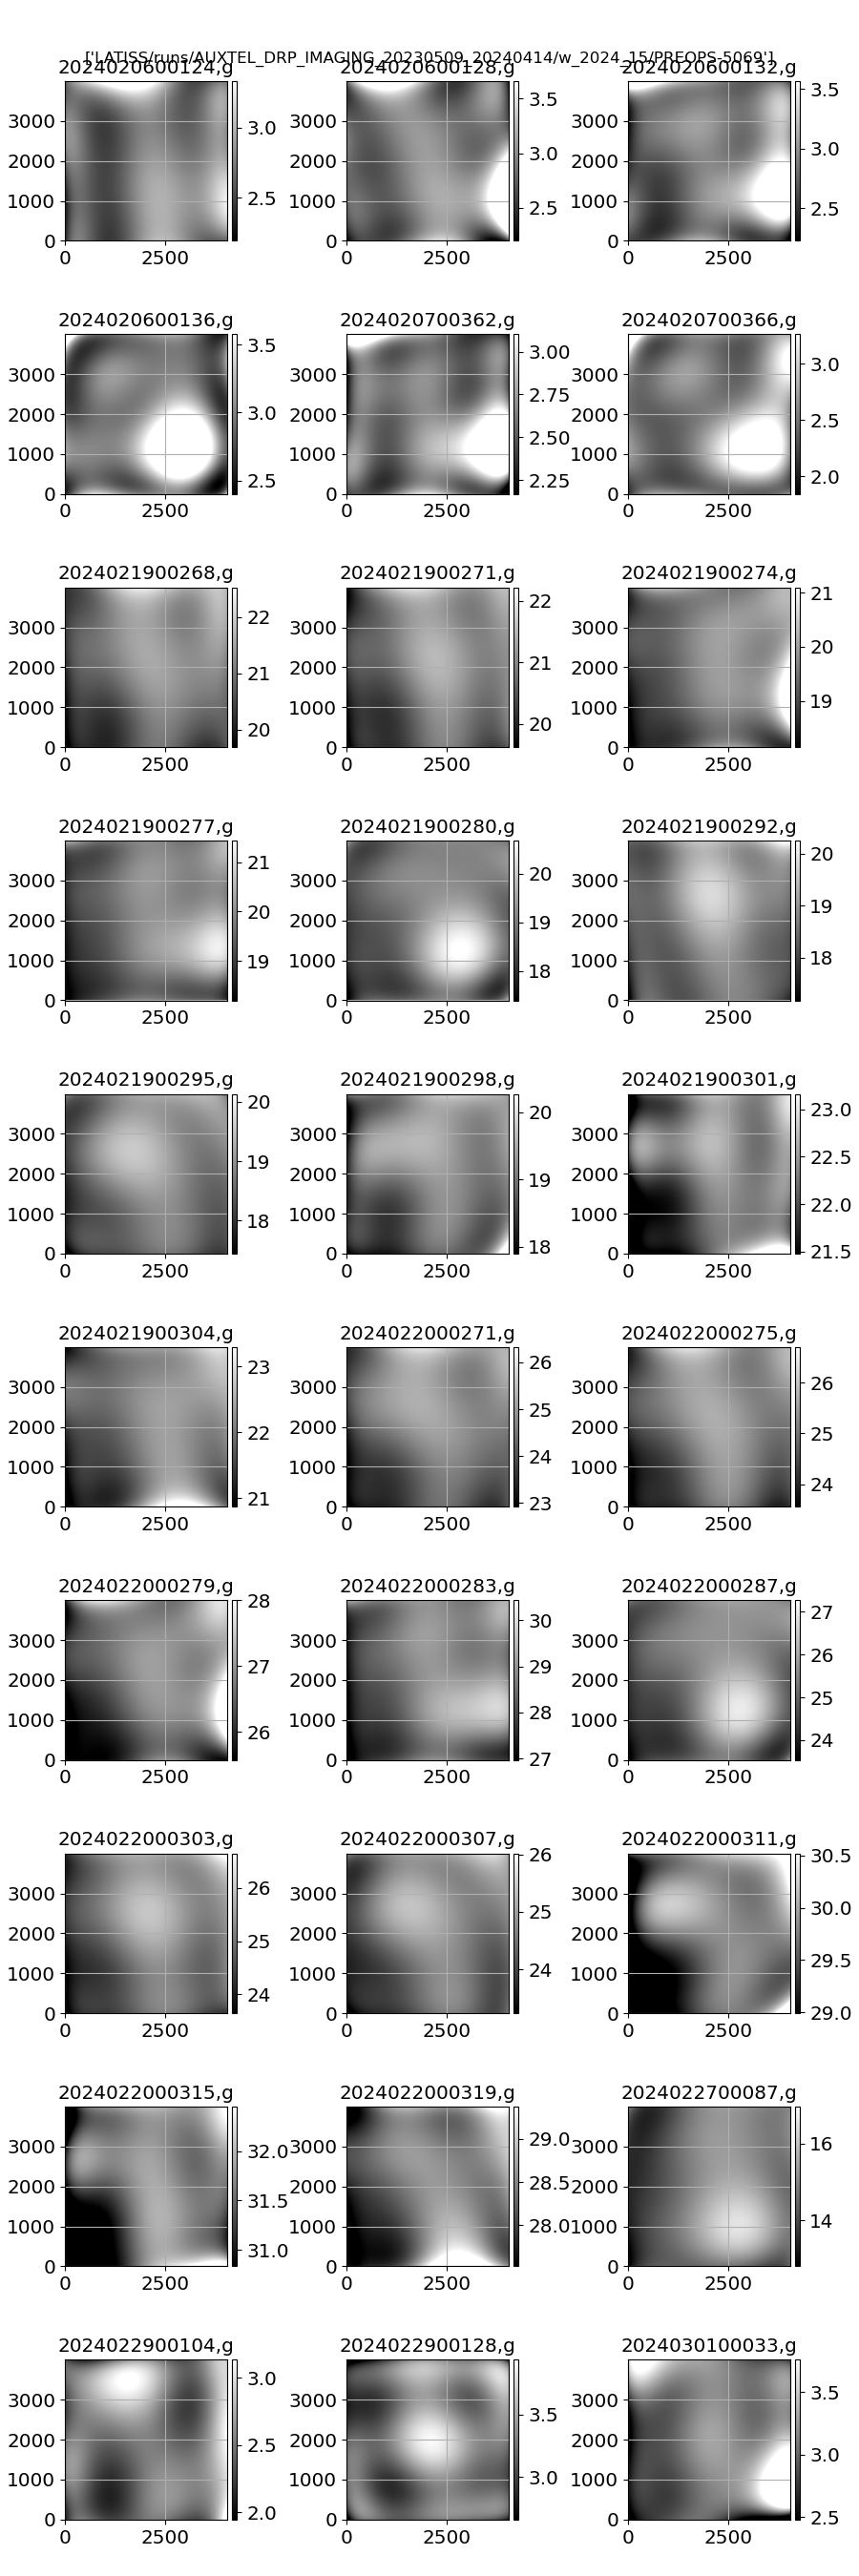

In [31]:
fig,axs = plt.subplots(NROWS,NCOLS,figsize=(NCOLS*3,NROWS*2.7))

for index,ax in enumerate(axs.flatten()):
    visitId = df_myselectedvisits.iloc[index0+index]['visitId']
    dataId = {'visit': visitId, 'instrument':instrument , 'detector': 0}
    bkgd = butler.get('calexpBackground', **dataId,collections=collections)
    img = bkgd.getImage()

    data_flat = img.array.flatten()
    med = np.median(data_flat)
    sigMad = 1.4826 * np.median(np.fabs(data_flat - med))
    vmin = med - 3 * sigMad
    vmax = med + 3 * sigMad

    im=ax.imshow(img.array, origin="lower",vmin=vmin, vmax=vmax, cmap="gray")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    the_title = f"{visitId},{band}"
    ax.set_title(the_title)
    ax.grid()
    ax.set_aspect('equal')
    plt.colorbar(im, cax=cax,ax=ax)

plt.suptitle(collections)
plt.tight_layout()
plt.show()
#remove_figure(fig)

## Background flux (Total ADU)

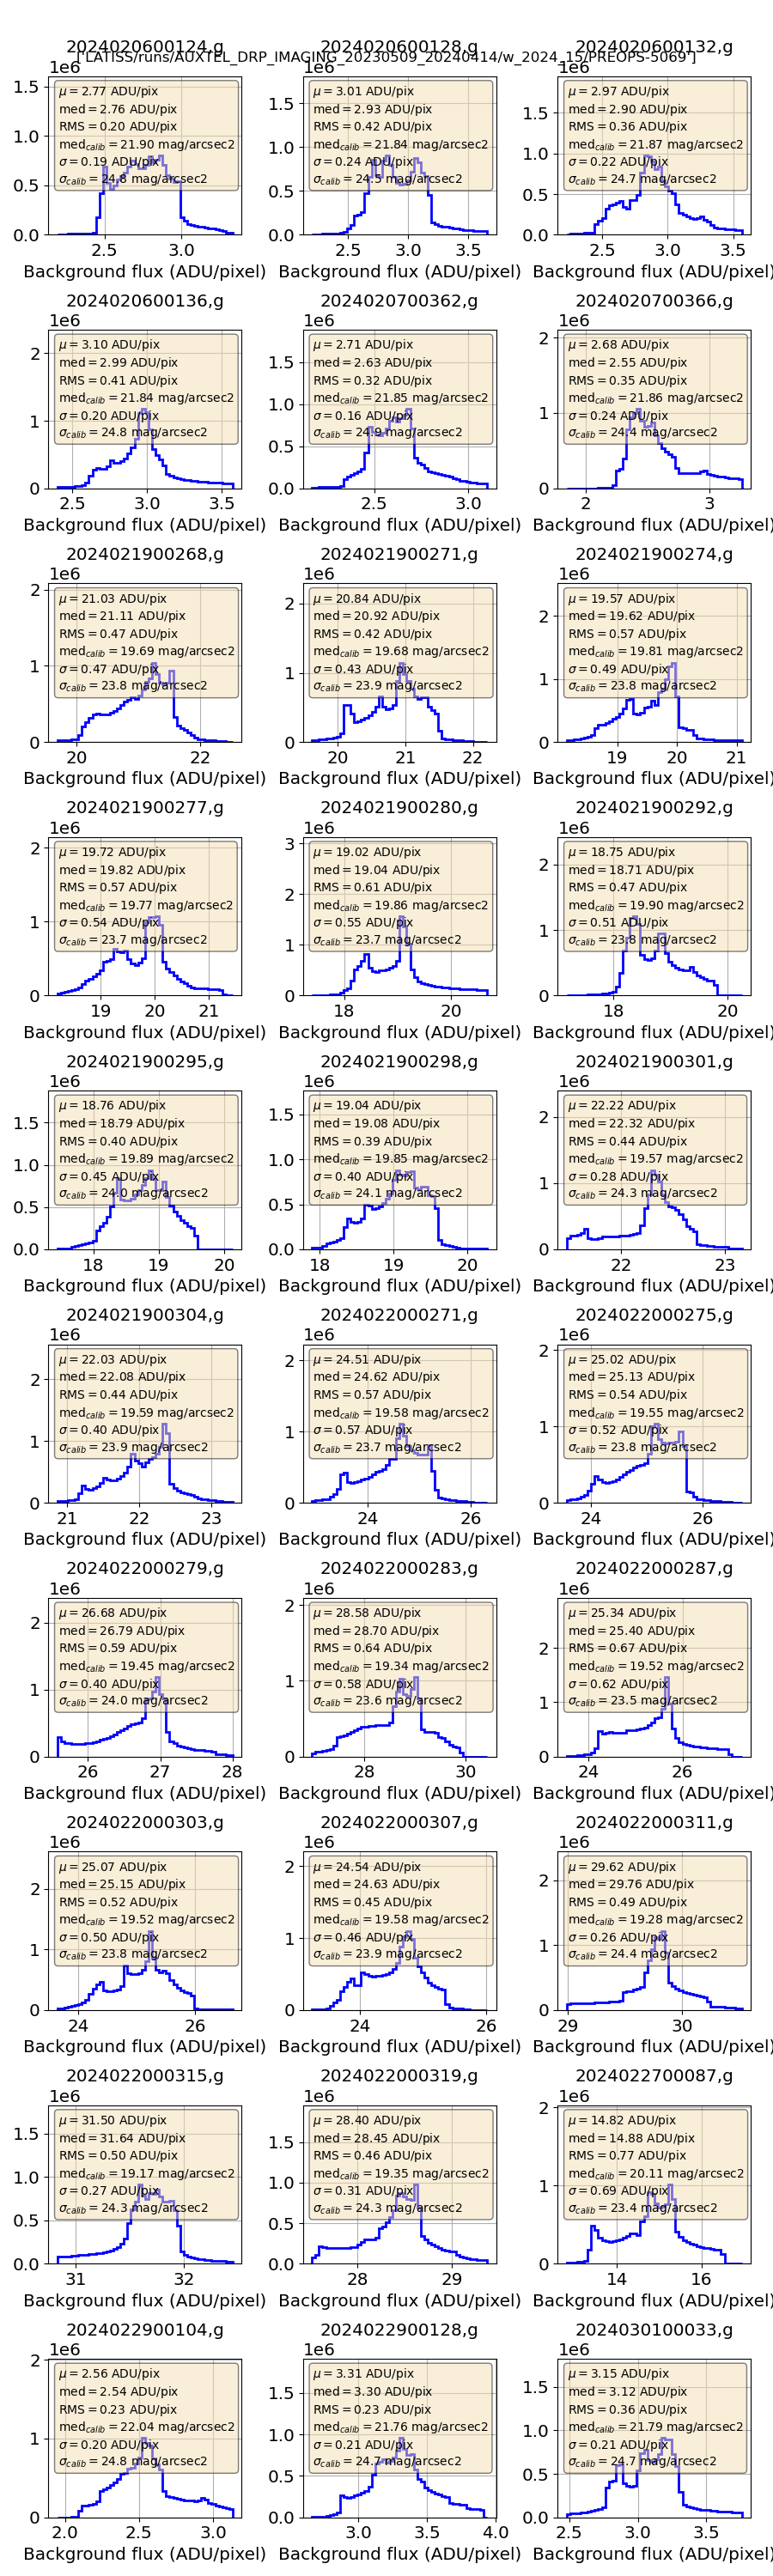

In [32]:
fig,axs = plt.subplots(NROWS,NCOLS,figsize=(NCOLS*3,NROWS*3))

for index,ax in enumerate(axs.flatten()):
    visitId = df_myselectedvisits.iloc[index0+index]['visitId']
    dataId = {'visit': visitId, 'instrument':instrument , 'detector': 0}
    calexp = butler.get('calexp', **dataId,collections=collections)
    calexp_info = calexp.getInfo()
    photocalib = calexp_info.getPhotoCalib()
    expo_photocalibconstant_mean = photocalib.getCalibrationMean()
    del calexp
    bkgd = butler.get('calexpBackground', **dataId,collections=collections)
    img = bkgd.getImage()

    data_flat = img.array.flatten()
    mu = np.mean(data_flat)
    med = np.median(data_flat)
    std = np.std(data_flat)
    sigMad = 1.4826 * np.median(np.fabs(data_flat - med))
    vmin = med - 3 * sigMad
    vmax = med + 3 * sigMad

    
    textstr = '\n'.join((
    r'$\mu=%.2f$ ADU/pix' % (mu, ),
    r'$\mathrm{med}=%.2f$ ADU/pix' % (med, ),
    r'$\mathrm{RMS}=%.2f$ ADU/pix' % (std, ),
    r'$\mathrm{med}_{calib}=%.2f$ mag/arcsec2' % (convert_fluxtomag(med*expo_photocalibconstant_mean/pixel_scale**2), ),
    r'$\sigma=%.2f$ ADU/pix' % (sigMad, ),
    r'$\sigma_{calib}=%.1f$ mag/arcsec2' % (convert_fluxtomag(sigMad*expo_photocalibconstant_mean/pixel_scale**2), )))

    histdata = ax.hist(data_flat,bins=50,range=(vmin,vmax),histtype="step",color="b",lw=2)
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)
    
    the_title = f"{visitId},{band}"
    ax.set_title(the_title)
    ax.set_xlabel("Background flux (ADU/pixel)")
    ax.grid()
    ax.set_ylim(0.,histdata[0].max()*2)
  
plt.suptitle(collections)
plt.tight_layout()
plt.show()
#remove_figure(fig)

## Background flux (ADU/pixels) in not masked pixels

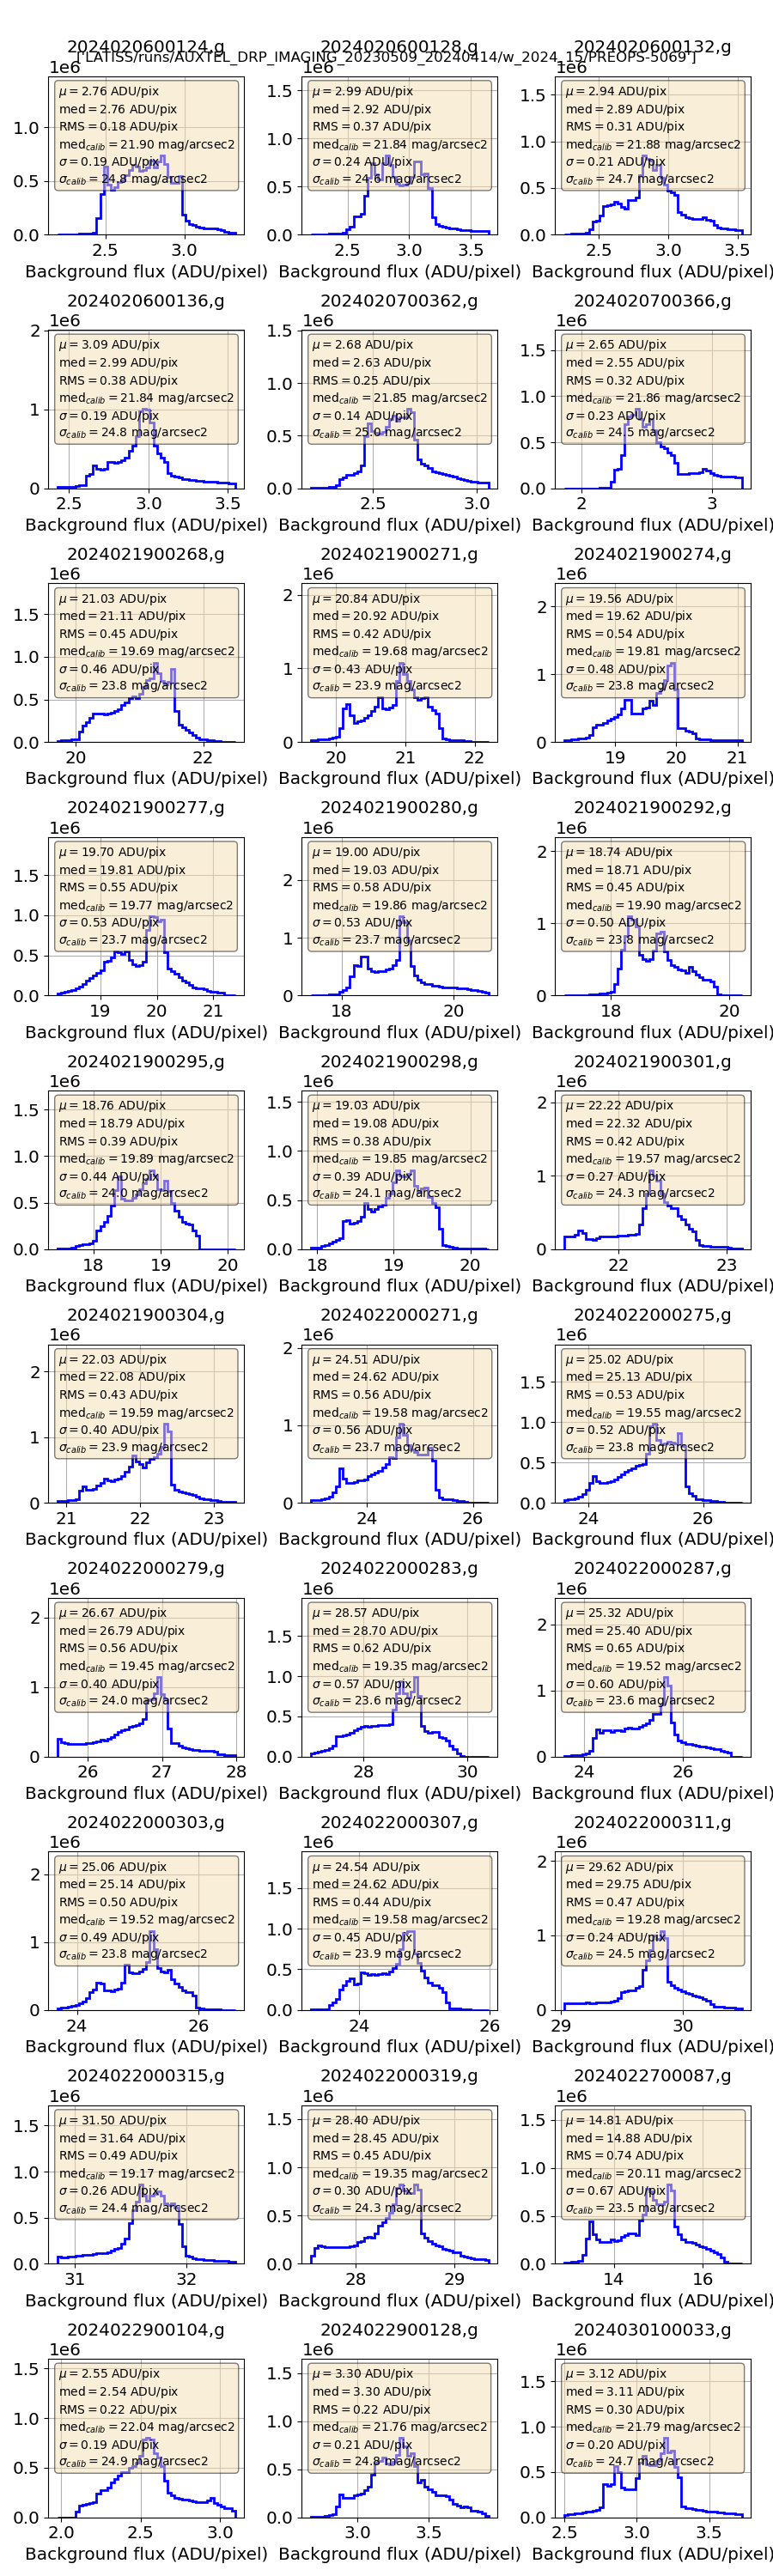

In [33]:
fig,axs = plt.subplots(NROWS,NCOLS,figsize=(NCOLS*3,NROWS*3))

for index,ax in enumerate(axs.flatten()):
    visitId = df_myselectedvisits.iloc[index0+index]['visitId']
    dataId = {'visit': visitId, 'instrument':instrument , 'detector': 0}
    calexp = butler.get('calexp', **dataId,collections=collections)
    calexp_info = calexp.getInfo()
    photocalib = calexp_info.getPhotoCalib()
    expo_photocalibconstant_mean = photocalib.getCalibrationMean()
    
    mask = calexp.mask.array
    the_mask = np.where(mask==0,1,0)
    bkgd = butler.get('calexpBackground', **dataId,collections=collections)
    img = bkgd.getImage().array* the_mask

    data_flat = img.flatten()
    data_flat_nozero = data_flat[~(data_flat==0)]
    mu = np.mean(data_flat_nozero )
    med = np.median(data_flat_nozero )
    std = np.std(data_flat_nozero)
    sigMad_nozero  = 1.4826 * np.median(np.fabs(data_flat_nozero  - med))
    vmin = med - 3 * sigMad_nozero 
    vmax = med + 3 * sigMad_nozero 

    
    textstr = '\n'.join((
    r'$\mu=%.2f$ ADU/pix' % (mu, ),
    r'$\mathrm{med}=%.2f$ ADU/pix' % (med, ),
    r'$\mathrm{RMS}=%.2f$ ADU/pix' % (std, ),
    r'$\mathrm{med}_{calib}=%.2f$ mag/arcsec2' % (convert_fluxtomag(med*expo_photocalibconstant_mean/pixel_scale**2), ),
    r'$\sigma=%.2f$ ADU/pix' % (sigMad_nozero , ),
    r'$\sigma_{calib}=%.1f$ mag/arcsec2' % (convert_fluxtomag(sigMad_nozero*expo_photocalibconstant_mean/pixel_scale**2 ), )))

    histdata = ax.hist(data_flat,bins=50,range=(vmin,vmax),histtype="step",color="b",lw=2)
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)
    
    the_title = f"{visitId},{band}"
    ax.set_title(the_title)
    ax.set_xlabel("Background flux (ADU/pixel)")
    ax.grid()
    ax.set_ylim(0.,histdata[0].max()*2.)
  
plt.suptitle(collections)
plt.tight_layout()
plt.show()
#remove_figure(fig)

## Relative Background compared to median in mag

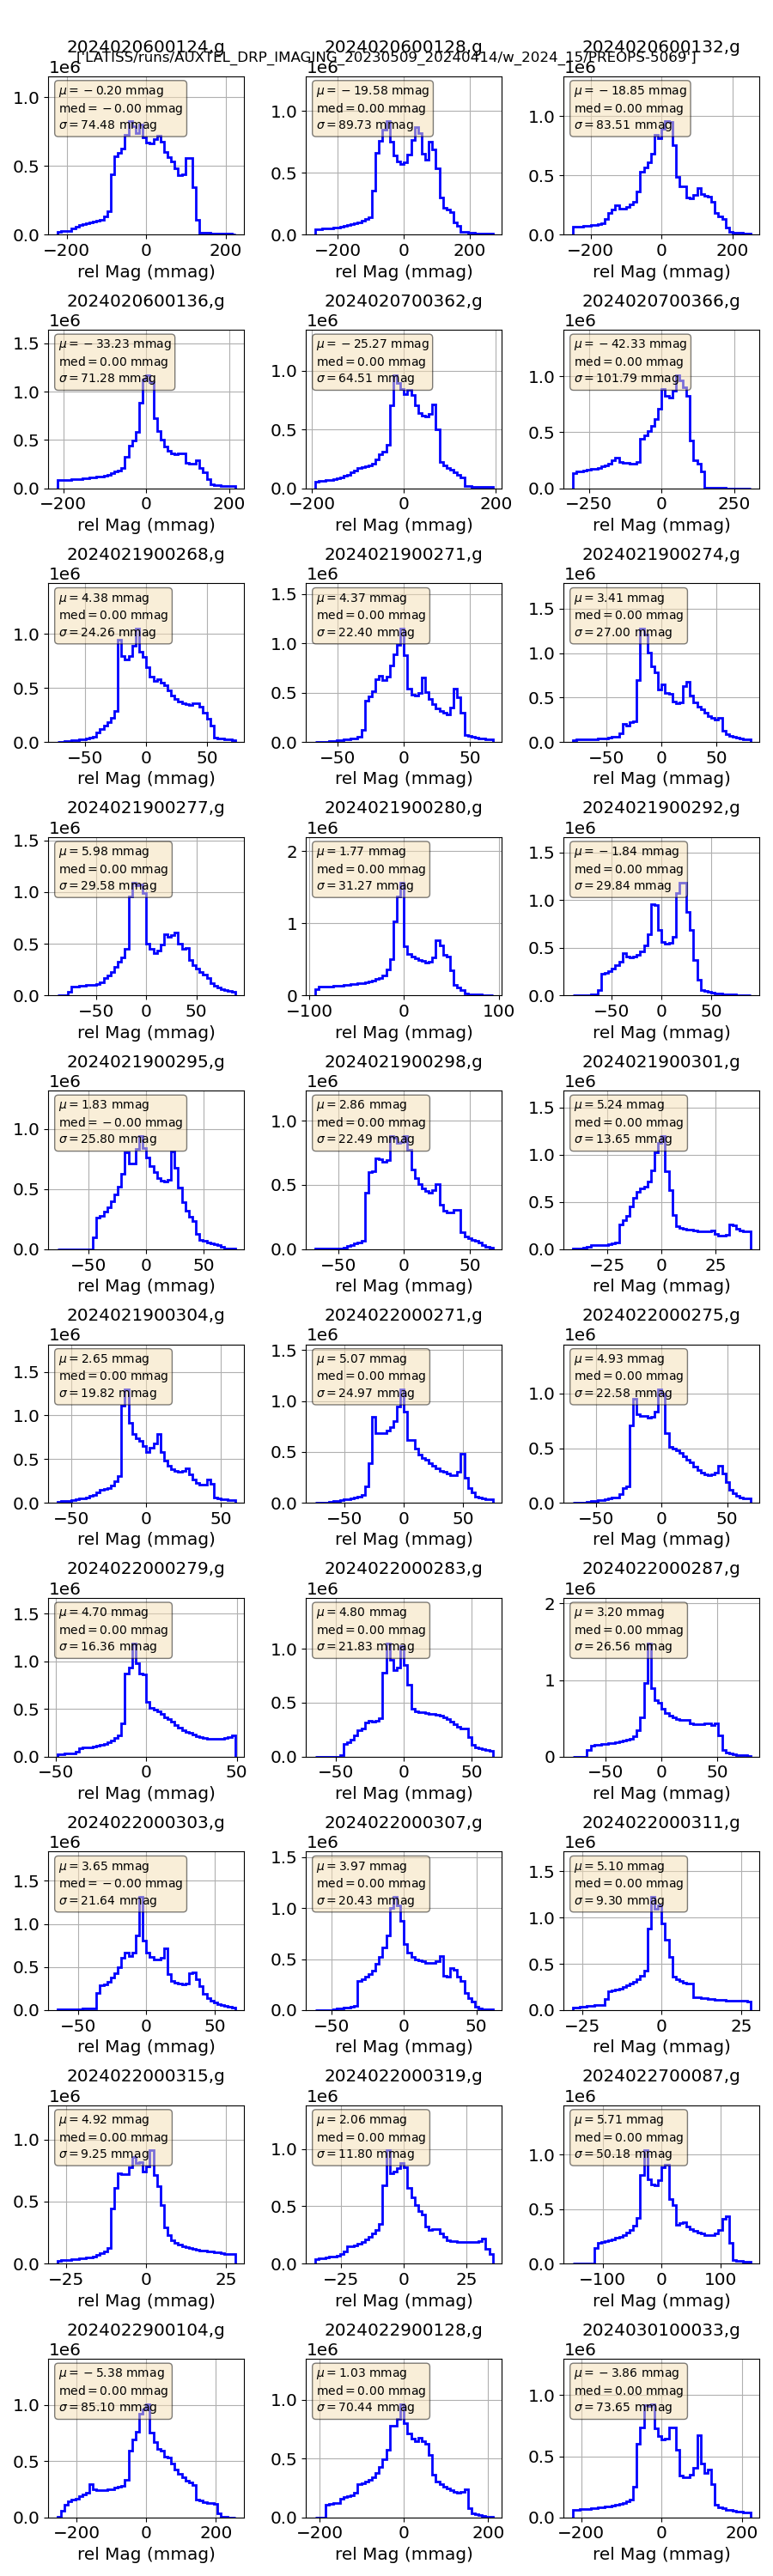

In [34]:
fig,axs = plt.subplots(NROWS,NCOLS,figsize=(NCOLS*3,NROWS*3))

for index,ax in enumerate(axs.flatten()):
    visitId = df_myselectedvisits.iloc[index0+index]['visitId']
    dataId = {'visit': visitId, 'instrument':instrument , 'detector': 0}
    bkgd = butler.get('calexpBackground', **dataId,collections=collections)
    img = bkgd.getImage()

    data_flat = img.array.flatten()
    med = np.median(data_flat)
    sigMad = 1.4826 * np.median(np.fabs(data_flat - med))
    vmin = med - 3 * sigMad
    vmax = med + 3 * sigMad

    data_flat_mag = -2.5*np.log10((data_flat/med))*1000
    mu_mag = np.mean(data_flat_mag)
    med_mag = np.median(data_flat_mag)
    sigMad_mag = 1.4826 * np.median(np.fabs(data_flat_mag - med_mag))
    vmin = med_mag - 3 * sigMad_mag
    vmax = med_mag + 3 * sigMad_mag
    textstr = '\n'.join((
    r'$\mu=%.2f$ mmag' % (mu_mag, ),
    r'$\mathrm{med}=%.2f$ mmag' % (med_mag, ),
    r'$\sigma=%.2f$ mmag' % (sigMad_mag , )))

    histdata = ax.hist(data_flat_mag,bins=50,range=(vmin,vmax),histtype="step",color="b",lw=2)
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)
    
    the_title = f"{visitId},{band}"
    ax.set_title(the_title)
    ax.set_xlabel("rel Mag (mmag)")
    ax.grid()
    ax.set_ylim(0.,histdata[0].max()*1.4)
  
plt.suptitle(collections)
plt.tight_layout()
plt.show()
#remove_figure(fig)